## Particle within radius or overlap calculations

In [1]:
#user-defined
# import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
from pyspark.sql import SparkSession

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist


#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns

#misc
import time
np.set_printoptions(suppress=True)

In [17]:
spark = SparkSession.builder \
    .master("local[4]") \
    .appName("Test.com") \
    .getOrCreate()

In [4]:
dir_save = '../../data/Sprints/AN/test/'
# dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_InterpolatedX.hdf'
# Total/Run03X.hdf'
dir = '~/Documents/MyFiles/DataAnalysis/data/Sprints/LowRes/Run01_expected.h5'

df = pd.read_hdf(dir)
dt= df.master_time[1]-df.master_time[0]

In [18]:

sparkDF=spark.createDataFrame(df) 
# sparkDF.printSchema()
sparkDF.show(n=2)

+--------------------+-------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-----+----+-----+----+----+-------------------------+-----------------------+--------------------+-------------------+
|         master_time|          sync_time|              xsrc|               ysrc|              odor|        trisonica_u|        trisonica_v|trisonica_pressure|trisonica_temperature|        gps_linear_x|        gps_linear_y|        gps_linear_z|       imu_angular_x|       imu_angular_y|       imu_angular_z|  imu_linear_acc_x|  imu_linear_acc_y|  imu_linear_acc_z|    U|   V|    D|  S2|mock|distance_along_streakline|nearest_from_streakline|distance_from_source|    relative_motion|
+--------------------+------------

### Calculate Expected encounters

In [5]:
sync_time = df.master_time-df.master_time[0]
df.insert(1,'sync_time',sync_time)

In [6]:
df.keys()

Index(['master_time', 'sync_time', 'xsrc', 'ysrc', 'odor', 'trisonica_u',
       'trisonica_v', 'trisonica_pressure', 'trisonica_temperature',
       'gps_linear_x', 'gps_linear_y', 'gps_linear_z', 'imu_angular_x',
       'imu_angular_y', 'imu_angular_z', 'imu_linear_acc_x',
       'imu_linear_acc_y', 'imu_linear_acc_z', 'U', 'V', 'D', 'S2', 'mock',
       'distance_along_streakline', 'nearest_from_streakline',
       'distance_from_source', 'relative_motion'],
      dtype='object')

In [8]:
# storing the odor location in a numpy array to avoid reading pandas
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 
# gps_location =  np.array([[df.gps_linear_x[i],df.gps_linear_y[i]] for i in range (len(df.gps_linear_x))]) 
source = np.array([[0,0]])
distance_from_source = np.array([cdist(odor_position,source)]).flatten()

# Is Encountered odor particle within the Calculated particle radius?

The loop below computes locations of the eastwest and northsouth particles and compares with a radius (distance) to interpret if the encountered particle were close to calculated particle. The execution for the loop is 23.56 seconds for 59770 rows of data

For stationery wind sensor: The loop below takes in ith eastwest and subtracts the ith U and V elements to get the i-1 state, as the eastwest is summation of all the wind positions. 

[3 + 2 + 1] = [6]

hence ith _state = 6

_state = _state-3

_state = _state-2

In [104]:
def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

In [159]:
def relative_motion_calculation(streakline, pos,i):
    if(pos == 0):
        x = streakline[pos:(pos+2),0]
        y = streakline[pos:(pos+2),1]
    else:
        x = streakline[(pos-1):(pos+2),0]
        y = streakline[(pos-1):(pos+2),1]

    slope_streakline,intercept_streakline=np.polyfit(x,y,1)
    slope_sensor = np.arctan2(df.gps_linear_y[i],df.gps_linear_x[i])
    
    relative_motion.append(wrapped_angular_diff(slope_streakline,slope_sensor))

In [202]:
def compute_distance(streakline, odor_position,i):
    source = np.array([[0,0]])
    streakline = np.concatenate((streakline,source))
    distance = cdist(odor_position,streakline).flatten()   # cdist compares distance for all the points in both arrays
    pos = np.where(distance == np.amin(distance))
    relative_motion_calculation(streakline, pos[0][0],i)
    nearest_from_streakline.append(np.min(distance))
    if (len(pos[0]) > 1):
        length=(np.sqrt(np.sum(np.diff(np.array(streakline[int(pos[0][0]):]), axis=0)**2, axis=1)))
    else:
        length=(np.sqrt(np.sum(np.diff(np.array(streakline[int(pos[0]):]), axis=0)**2, axis=1)))
        
    distance_along_streakline.append(np.sum(length))

In [203]:
def find_streakline():
    eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df))]
    northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]
    return eastwest,northsouth

In [204]:
eastwest,northsouth =find_streakline()

In [205]:
nearest_from_streakline = []
distance_along_streakline = []
relative_motion=[]

for i in range(len(eastwest)-1, 6000, -1):
    odor_pos = [odor_position[i]] 
    eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
    compute_distance(wind_pos,odor_pos,i)

In [206]:
#for the section when only the length of the elements is equal to the window value
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
        distance = cdist(odor_pos,wind_pos).flatten()
        slope_sensor = np.arctan2(df.gps_linear_y[i],df.gps_linear_x[i])
        #manual appending for source position 
        #to avoid zeroth error
        relative_motion.append(wrapped_angular_diff(0,slope_sensor))
        distance_along_streakline.append(0)
        nearest_from_streakline.append(np.min(distance))
        
    else:
        eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        compute_distance(wind_pos,odor_pos,i)


In [209]:
## flip containers because above iteration is done in reverse order
df['mock'] = np.zeros(len(df)) 
# odor_presence = odor_presence[::-1]
# max_radius = max_radius[::-1]

## storing in the dataframe 
# df['odor_expected'] = odor_presence
df['distance_along_streakline'] =  distance_along_streakline[::-1]
df['nearest_from_streakline'] = nearest_from_streakline[::-1] #nearest_from_streakline
df['relative_motion']=relative_motion[::-1]
df['distance_from_source'] = distance_from_source

In [79]:
query = 'odor>=2'
df_occurence = df.query(query)

x = np.linspace(0,25,25)
y = np.linspace(0,25,25)

H1, x, y = np.histogram2d(df_occurence.distance_along_streakline, df_occurence.nearest_from_streakline, bins=(x, y), 
                          weights = df_occurence.odor)
H1 = H1.T 
H2, x, y = np.histogram2d(df.distance_along_streakline, df.nearest_from_streakline, bins=(x, y), 
                          weights = df.odor)
H2 = H2.T 
Encounters = np.array(H1)/np.array(H2)
Encounters[Encounters == np.inf] = 0

<ipython-input-79-d4bfa6ef7d6c>:13: RuntimeWarning: invalid value encountered in true_divide
  Encounters = np.array(H1)/np.array(H2)


In [80]:
#filtering
Total = H2
N_Encounter = H1
for i in range (len(Total)):
    for j in range(len(Total[i])):
        if Total[i][j]<400:
            Total[i][j] =0
            N_Encounter[i][j]=0

Encounters = np.array(N_Encounter)/np.array(Total)
Encounters[Encounters == np.inf] = 0

<ipython-input-80-4e1cd30133a5>:10: RuntimeWarning: invalid value encountered in true_divide
  Encounters = np.array(N_Encounter)/np.array(Total)


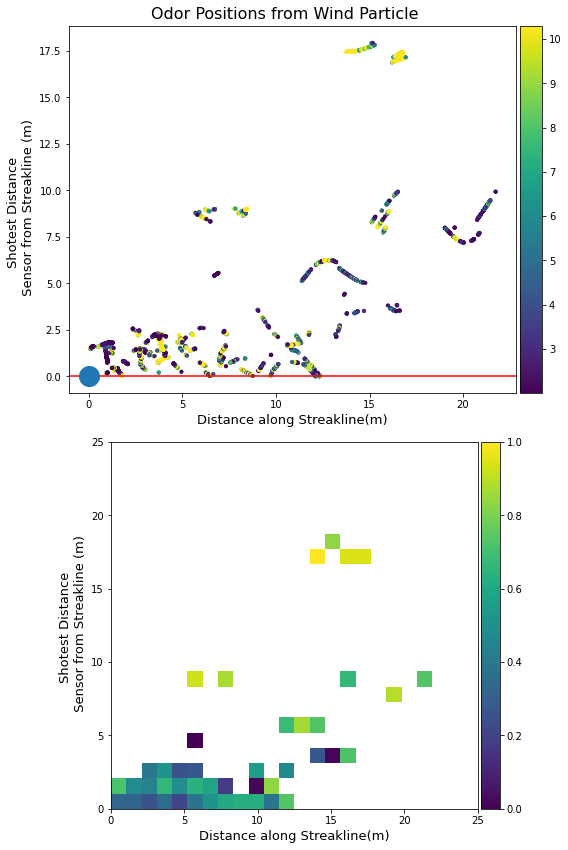

In [72]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(8,12) , gridspec_kw={'height_ratios': [4,4]})

#plot wind vs odor from source and each other
f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df_occurence.distance_along_streakline, df_occurence.nearest_from_streakline, cmap = 'viridis', 
                  c = df_occurence.odor,  s = 10)
ax1.set_xlabel('Distance along Streakline(m)' , fontsize = 13)
ax1.set_ylabel('Shotest Distance \n Sensor from Streakline (m)' , fontsize = 13)


divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'vertical')

# x = np.linspace(0,25,11)
# y = np.linspace(0,10,25)
ax2.set_xlabel('Distance along Streakline(m)', fontsize = 13)
ax2.set_ylabel('Shotest Distance \n Sensor from Streakline (m)', fontsize = 13)
var2 = ax2.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'viridis', extent=[x[0], x[-1], y[0], y[-1]])
start, end = ax2.get_xlim()

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()

# f.savefig(dir_save+'Run03Set05_NewStreak_Filtered.jpeg')